In [1]:
import cv2
import numpy as np
import scipy.io
import scipy.optimize
from scipy import stats
import matplotlib.pyplot as plt
from matplotlib import gridspec 
import pandas
#import magni
import math
from PIL import Image
#import seaborn as sns; sns.set()
from sklearn.cross_validation import train_test_split
from sklearn import metrics
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
%matplotlib inline

<a id='visualize'></a>
## Finding objects in the data: Using the Canny edge detector in [OpenCV](https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_imgproc/py_canny/py_canny.html#canny)

**Edge vs region based techniques:**
* Edge detection based methods of finding objects focus on the expectation of a gradient at the object's edge and the background
* Region based methods focus on the object itself

** How the Canny edge dection algorithm works:**
1. Use a [convolution operator](http://homepages.inf.ed.ac.uk/rbf/HIPR2/gsmooth.htm) to remove noise. In this case we apply a 5x5 guassian operator/filter. 
    * The idea behind filter-based approaches to reducing noise is to consider a window of surrounding pixels and use a combination of their values to replace the current pixel.
![](4.png)
![](5.png)
2. Use a convolution method to find edge gradients and angles. That is, weight the discrete sum of the image with another discrete function, the spatial mask. In this case, the Sobel operator is the spatial mask. OpenCV rounds this angle as one of four directions; the gradient is always perpendicular to the edge direction
![](1.png)
3. Use non-maximum suppression to turn pixel values to zero if they don't exist at a local maximum in its neighborhood in the direction of the gradient. An effective method of thinning the edge
![](2.png)
4. Perform hysteresis thresholding. Rather than instatiating a cut off for gradients values, pixels greater than a max value are binned as edges, pixels less than a min value are binned as not edges, and anything between is classified as an edge it is connected to max value binned edges. 
![](3.png)    

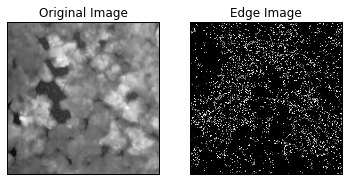

In [6]:
img = cv2.imread('height.jpg',0)

#Python: cv.Canny(image, edges, threshold1, threshold2, aperture_size=3) → None
edges = cv2.Canny(img,0,10,3)

plt.subplot(121),plt.imshow(img,cmap = 'gray')
plt.title('Original Image'), plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(edges,cmap = 'gray')
plt.title('Edge Image'), plt.xticks([]), plt.yticks([])

plt.show()

** Cons of the edge-based method and the OpenCV Canny edge dector:**
* Success is dependent on how well the object is separated from the background (the severity of the generated pixel gradient at the edge)
* Can't adjust the gaussian filter, where there is a trade-off between size of the filter and reduction in noise. Actually, Canny had first suggested using different values of sigma and resulting edge images be integrated for the final result. Larger sigmas capture coarser details in the image.
* Can't employ other filters such as the wavelet-based approaches
    
** Pros **
* Can adjust the size of the sobel kernel, high and low pass filters

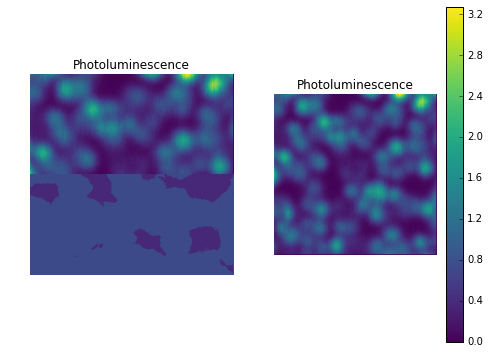

In [3]:
import numpy as np
import scipy.io
import scipy.optimize
from scipy import stats
import matplotlib.pyplot as plt
from matplotlib import gridspec
from ipywidgets import interact, FloatSlider, RadioButtons, IntSlider
import pandas
import math
from sklearn.cross_validation import train_test_split
from sklearn import metrics
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
%matplotlib inline

def myround(x, base):
    return (float(base) * round(float(x)/float(base)))

params = {
    'lines.markersize' : 3,
    'axes.labelsize': 10,
    'font.size': 10,
    'legend.fontsize': 10,
    'xtick.labelsize': 10,
    'ytick.labelsize': 10,
    'text.usetex': False,
    
   }


#plp.rcParams.update(params)
plt.rcParams.update(params)
Ht2 = np.loadtxt('./data/MABr.1.Ht.txt',skiprows=0, dtype=np.float64)
Po2 = np.loadtxt('./data/MABr.1.Po.txt',skiprows=0, dtype=np.float64)
Ph2 = np.loadtxt('./data/MABr.1.Ph.txt',skiprows=0, dtype=np.float64)
Am2 = np.loadtxt('./data/MABr.1.Am.txt',skiprows=0, dtype=np.float64)
Pl2 = np.loadtxt('./data/MABr.1.Pl.txt',skiprows=0, dtype=np.float64)

# flatten the images
Ht2_flat = Ht2.flatten()
Po2_flat = Po2.flatten()
Ph2_flat = Ph2.flatten()
Am2_flat = Am2.flatten()
Pl2_flat = Pl2.flatten()

plt.show()
X = [Ht2_flat, Po2_flat, Ph2_flat, Am2_flat]
X = np.array(X).T
Y = np.array(Pl2_flat).T


Xtrain = np.array([Ht2_flat[0:31625], Po2_flat[0:31625], Ph2_flat[0:31625], Am2_flat[0:31625]]).T
Xtest = np.array([Ht2_flat[31625:], Po2_flat[31625:], Ph2_flat[31625:], Am2_flat[31625:]]).T
Ytrain = np.array(Pl2_flat[0:31625])
Ytest = np.array(Pl2_flat[31625:])

depth_slider = IntSlider(min=1, max=20, step=1, value=2)
@interact(Depth=depth_slider,continuous_update=False)

def plot(Depth):#,Xtrain,Xtest,Ytrain,Ytest,Ht2):
    clf = DecisionTreeRegressor(max_depth=Depth)
    clf.fit(Xtrain, Ytrain)
    Ypred = clf.predict(Xtest)

    x = Ht2.shape[0]
    y = Ht2.shape[1]
    k=0
    merge = np.concatenate((Ytrain,Ypred))
    Pl_predict = np.zeros((x,y))
    for i in range(x):
        for j in range (y):
            Pl_predict[i,j] = merge[k]
            k = k + 1
        
    fig = plt.figure(figsize=(8,6))
    pl_ax = fig.add_subplot(121)
    pl_ax.imshow(Pl_predict, cmap='viridis')
    pl_ax.set_title('Photoluminescence')
    pl_ax.axis('off')
    pl_ax = fig.add_subplot(122)
    cax = pl_ax.imshow(Pl2, cmap='viridis')
    pl_ax.set_title('Photoluminescence')
    pl_ax.axis('off')

    fig.colorbar(cax)